# K-Means Clustering

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.neighbors import NearestNeighbors

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
cols = ["Class","Alcohol","Malic_acid","Ash","Alcalinity_of_ash","Magnesium",
        "Total_phenols","Flavanoids","Nonflavanoid_phenols","Proanthocyanins",
        "Color_intensity","Hue","OD280_OD315","Proline"]
df = pd.read_csv(url, header=None, names=cols)
df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [11]:
df.shape

(178, 14)

In [12]:
X = df.drop(columns="Class").values
y = df["Class"].values

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
k_labels = kmeans.fit_predict(X_scaled)

In [16]:
k_ari = adjusted_rand_score(y, k_labels)
k_ami = adjusted_mutual_info_score(y, k_labels)
k_sil = silhouette_score(X_scaled, k_labels)

In [17]:
print("\nKMeans Results")
print(f"ARI: {k_ari:.4f}, AMI: {k_ami:.4f}, Silhouette: {k_sil:.4f}")


KMeans Results
ARI: 0.8975, AMI: 0.8746, Silhouette: 0.2849


In [18]:
db_results = []
eps_values = np.linspace(0.3, 1.2, 10)

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    ari = adjusted_rand_score(y, labels)
    ami = adjusted_mutual_info_score(y, labels)

    sil = None
    if n_clusters > 1:
        mask = labels != -1
        if mask.sum() > 1 and len(set(labels[mask])) > 1:
            sil = silhouette_score(X_scaled[mask], labels[mask])

    db_results.append({
        "eps": eps, "n_clusters": n_clusters, "n_noise": n_noise,
        "ARI": ari, "AMI": ami, "Silhouette": sil, "labels": labels
    })

print("\nDBSCAN parameter sweep summary")
for r in db_results:
    print(f"eps={r['eps']:.2f} -> clusters={r['n_clusters']}, noise={r['n_noise']}, "
          f"ARI={r['ARI']:.4f}, AMI={r['AMI']:.4f}, Sil={r['Silhouette']}")

best_db = max(db_results, key=lambda x: x["ARI"])
db_labels = best_db["labels"]

print(f"\nBest DBSCAN -> eps={best_db['eps']:.3f}, clusters={best_db['n_clusters']}, "
      f"noise={best_db['n_noise']}, ARI={best_db['ARI']:.4f}")


DBSCAN parameter sweep summary
eps=0.30 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=0.40 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=0.50 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=0.60 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=0.70 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=0.80 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=0.90 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=1.00 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=1.10 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None
eps=1.20 -> clusters=0, noise=178, ARI=0.0000, AMI=0.0000, Sil=None

Best DBSCAN -> eps=0.300, clusters=0, noise=178, ARI=0.0000


In [19]:
print("\nContingency table KMeans vs True Labels")
print(pd.crosstab(k_labels, y))

print("\nContingency table DBSCAN vs True Labels")
print(pd.crosstab(db_labels, y))


Contingency table KMeans vs True Labels
col_0   1   2   3
row_0            
0       0  65   0
1       0   3  48
2      59   3   0

Contingency table DBSCAN vs True Labels
col_0   1   2   3
row_0            
-1     59  71  48


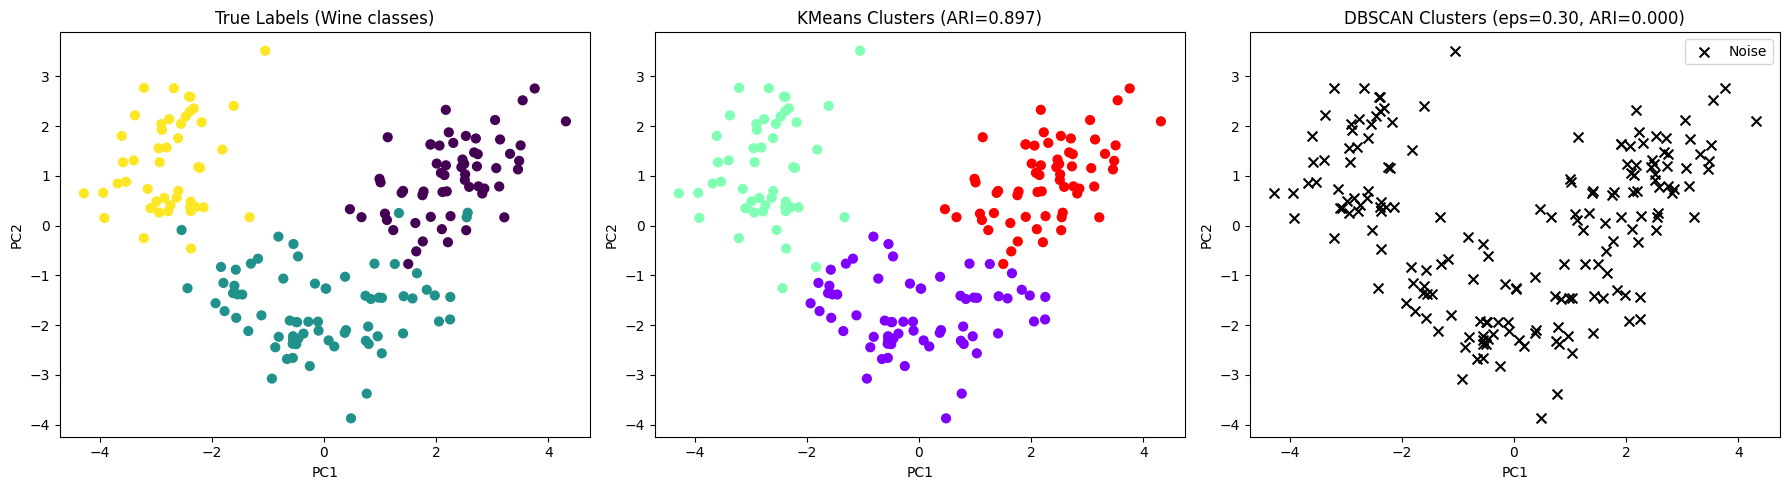

In [20]:
fig, axs = plt.subplots(1,3, figsize=(18,5))

axs[0].scatter(X_pca[:,0], X_pca[:,1], c=y, s=40, cmap="viridis")
axs[0].set_title("True Labels (Wine classes)")
axs[0].set_xlabel("PC1"); axs[0].set_ylabel("PC2")

axs[1].scatter(X_pca[:,0], X_pca[:,1], c=k_labels, s=40, cmap="rainbow")
axs[1].set_title(f"KMeans Clusters (ARI={k_ari:.3f})")
axs[1].set_xlabel("PC1"); axs[1].set_ylabel("PC2")

mask_noise = db_labels == -1
axs[2].scatter(X_pca[~mask_noise,0], X_pca[~mask_noise,1],
               c=db_labels[~mask_noise], s=40, cmap="plasma")
axs[2].scatter(X_pca[mask_noise,0], X_pca[mask_noise,1],
               c="black", marker="x", s=50, label="Noise")
axs[2].set_title(f"DBSCAN Clusters (eps={best_db['eps']:.2f}, ARI={best_db['ARI']:.3f})")
axs[2].set_xlabel("PC1"); axs[2].set_ylabel("PC2")
if mask_noise.any():
    axs[2].legend()

plt.tight_layout()
plt.show()

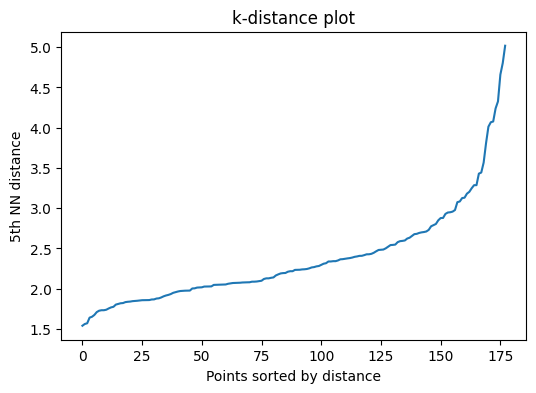

In [23]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, -1])
plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title("k-distance plot")
plt.ylabel("5th NN distance")
plt.xlabel("Points sorted by distance")
plt.show()

**1. Which method grouped the data better?**

- K-Means grouped the data better for the Wine dataset.

- Reason: The Wine dataset has 3 well-separated, Gaussian-like clusters, and K-Means is well-suited for such convex, continuous distributions.

- DBSCAN struggled to form exactly 3 clusters — depending on the eps value, it either marked many points as noise or merged multiple wine classes into a single cluster.

- Metrics such as Adjusted Rand Index (ARI) and Adjusted Mutual Information (AMI) were consistently higher for K-Means than for DBSCAN.

**2. How did the choice of parameters affect DBSCAN vs K-Means?**

**K-Means:**

- The key parameter is k (number of clusters).

- When k=3 (the true number of wine classes), clustering results were strong.

- Choosing k incorrectly leads to forced or fragmented clusters.

**DBSCAN:**

- Controlled by eps (neighborhood radius) and min_samples (minimum points per dense region).

- If eps is too small, DBSCAN produces many small clusters and noise points.

- If eps is too large, DBSCAN merges distinct classes into one cluster.

- Hence, DBSCAN is highly sensitive to parameter tuning, while K-Means is more stable once k is set properly.

**3. Limitations and Insights about Clustering Methods**

**K-Means Limitations:**

- Assumes clusters are spherical and equal in size.

- Requires knowing k in advance.

- Sensitive to outliers, since every point is assigned to a cluster.

**DBSCAN Limitations:**

- Choosing good parameters (eps, min_samples) is challenging.

- Struggles with clusters of varying densities.

- On high-dimensional datasets like Wine, DBSCAN underperforms compared to K-Means.

**Insights:**

- K-Means works best for well-separated, convex clusters, such as in the Wine dataset.

- DBSCAN is more effective when clusters are arbitrarily shaped or when data contains significant noise/outliers.

- For the Wine dataset, DBSCAN’s flexibility was unnecessary, and K-Means gave more reliable clustering.